# Advanced Lane Finding Project

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

### Calibrate camera & undistort images

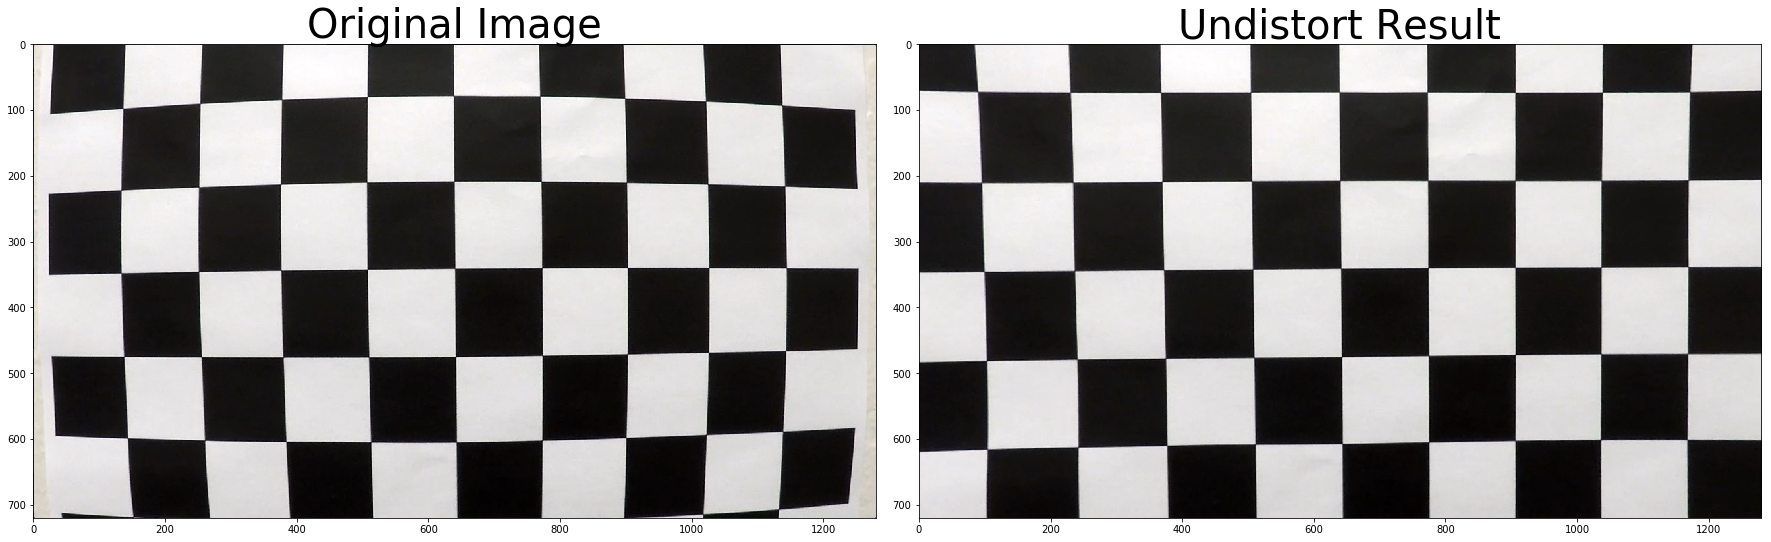

In [3]:
class Image_Undistortor:
    def __init__(self, calib_dir='camera_cal/calibration*.jpg'):
        self._mtx, self._dist = self._calib_camera(calib_dir)
    
    def _calib_camera(self, calib_dir):
        objpoints = []
        imgpoints = []

        nx = 9
        ny = 6

        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)

        image_files = glob.glob(calib_dir)

        for filename in image_files:
            # read calib image
            img = mpimg.imread(filename)

            # grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            if ret:
                imgpoints.append(corners)
                objpoints.append(objp)

                # draw corners
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                           imgpoints, gray.shape[::-1], None, None)

        return mtx, dist

    def undistort(self, img):
        return cv2.undistort(img, self._mtx, self._dist, None, self._mtx)

    
    
undistortor = Image_Undistortor()
    
image = mpimg.imread('camera_cal/calibration1.jpg')
result = undistortor.undistort(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Undistort Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

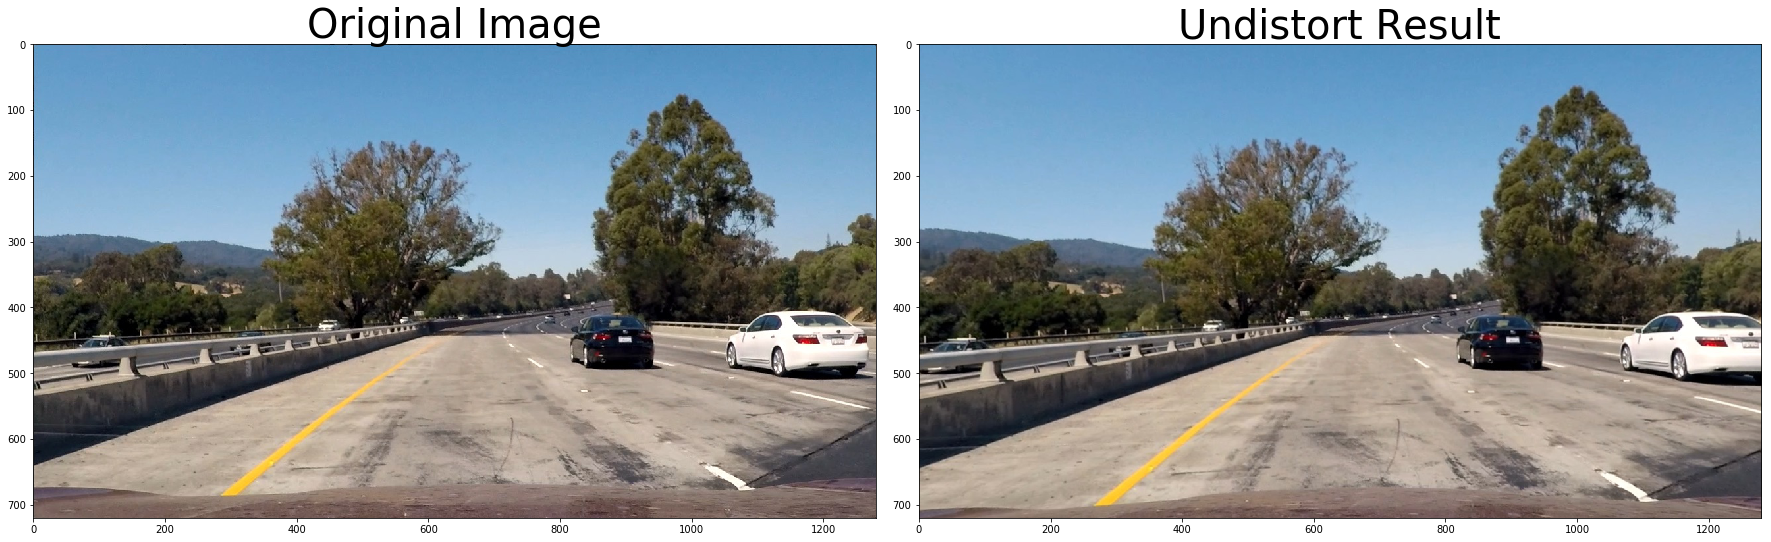

In [6]:
image = mpimg.imread('test_images/test1.jpg')
result = undistortor.undistort(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Undistort Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholding

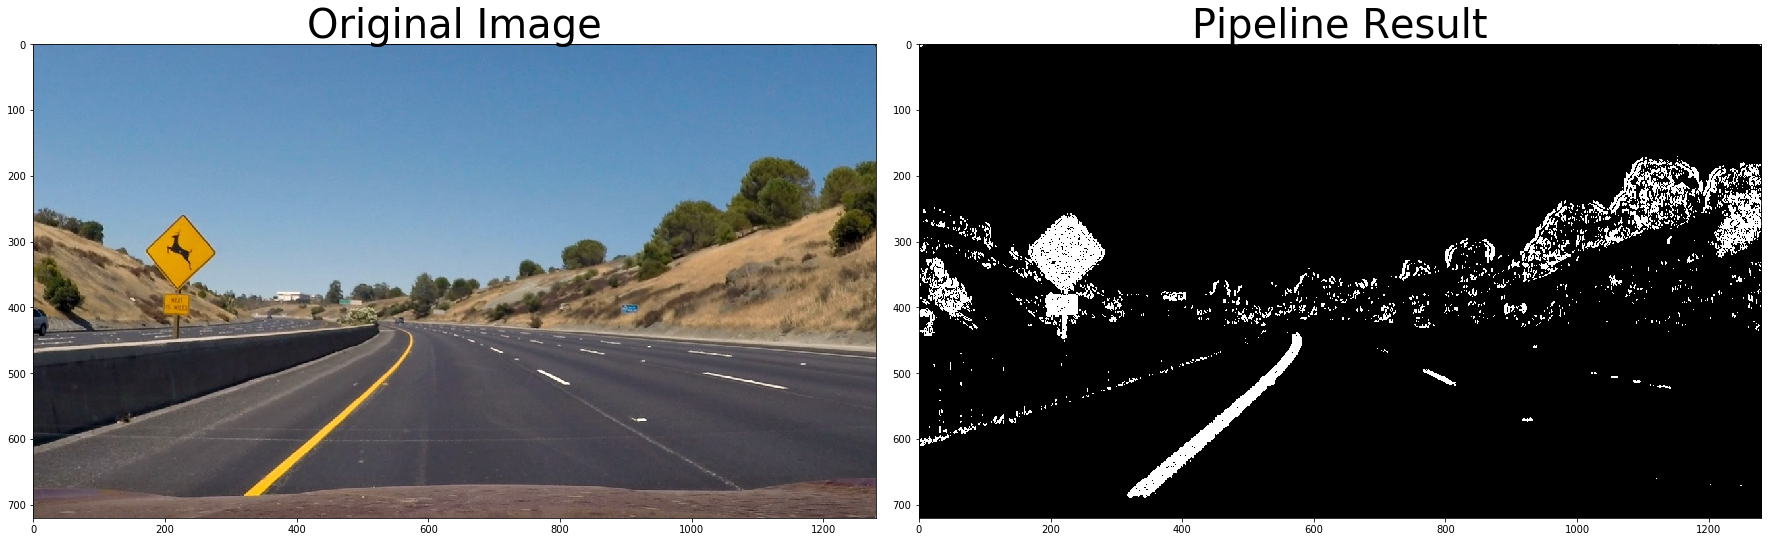

In [8]:
hyper_params = {
    'x': {
        'kernel': 5,
        'thresh': (0, 255),
    },
    'y': {
        'kernel': 5,
        'thresh': (0, 255),
    },
    'mag': {
        'thresh': (15, 150),
    },
    'dir': {
        'kernel': 3,
        'thresh': (0.1, np.pi/2),
    },
    's_channel': {
        'thresh': (170, 255),
    },
}



class Color_Grad_Pipeline:
    def __init__(self, hyper_params=hyper_params):
        self._hyper_params = hyper_params
        
    def process(self, img):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        # sobel
        mag_bin, dir_bin = self._sobel_thresh(s_channel)
        
        # channel
        s_bin = self._color_thresh(s_channel)
        
        # combine
        combine = np.zeros_like(s_channel)
        mask = ((mag_bin == 1) | ((dir_bin == 1) & (s_bin == 1)))
        combine[mask] = 1
        
        # mask front view
        
        return combine
    
    def _color_thresh(self, channel):
        thresh = self._hyper_params['s_channel']['thresh']
        s_bin = np.zeros_like(channel)
        mask = (channel >= thresh[0]) & (channel <= thresh[1])
        s_bin[mask] = 1
        return s_bin
        
    def _calc_sobel(self, channel, orient='x'):
        assert orient in ('x', 'y')
        if 'x' == orient:
            dx, dy = 1, 0
        else:
            dx, dy = 0, 1
        sobel = cv2.Sobel(channel, cv2.CV_64F, dx, dy,
                       ksize=self._hyper_params[orient]['kernel'])
        return np.absolute(sobel)
    
#    def _sobel_thresh_masker(self, abs_sobel, orient='x'):
#        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
#        thresh_min, thresh_max = self._hyper_params[orient]['thresh']
#        mask = (scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)
#        sobel_bin = np.zeros_like(scaled_sobel)
#        sobel_bin[mask] = 1
#        return sobel_bin
    
    def _xy_mag(self, channel):
        sobel_x, sobel_y = [self._calc_sobel(channel, orient) for orient in ('x', 'y')]
        mag = np.sqrt(sobel_x**2, sobel_y**2)
        scaled_mag = np.uint8(255 * mag / np.max(mag))
        thresh_min, thresh_max = self._hyper_params['mag']['thresh']
        mask = (scaled_mag >= thresh_min) & (scaled_mag <= thresh_max)
        mag_bin = np.zeros_like(channel)
        mag_bin[mask] = 1
        
        return sobel_x, sobel_y, mag_bin

    def _sobel_thresh(self, channel):
        sobel_x, sobel_y, mag_bin = self._xy_mag(channel)
        #sobel_x_bin, sobel_y_bin = [self._sobel_thresh_masker(sobel, orient)
                                   ##for sobel, orient in zip((sobel_x, sobel_y), ('x', 'y'))]
            
        # calc dir
        dir_bin = self._dir_thresh(sobel_x, sobel_y)
        
        return mag_bin, dir_bin
    
    def _dir_thresh(self, sobel_x, sobel_y):
        theta = np.arctan2(sobel_y, sobel_x)
        dir_thresh_min, dir_thresh_max = self._hyper_params['dir']['thresh']
        mask = (theta > dir_thresh_min) & (theta <= dir_thresh_max)
        dir_bin = np.zeros_like(theta)
        dir_bin[mask] = 1
        
        return dir_bin


image = mpimg.imread('test_images/test2.jpg')

grad_pipeline = Color_Grad_Pipeline(hyper_params)
result = grad_pipeline.process(image)
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

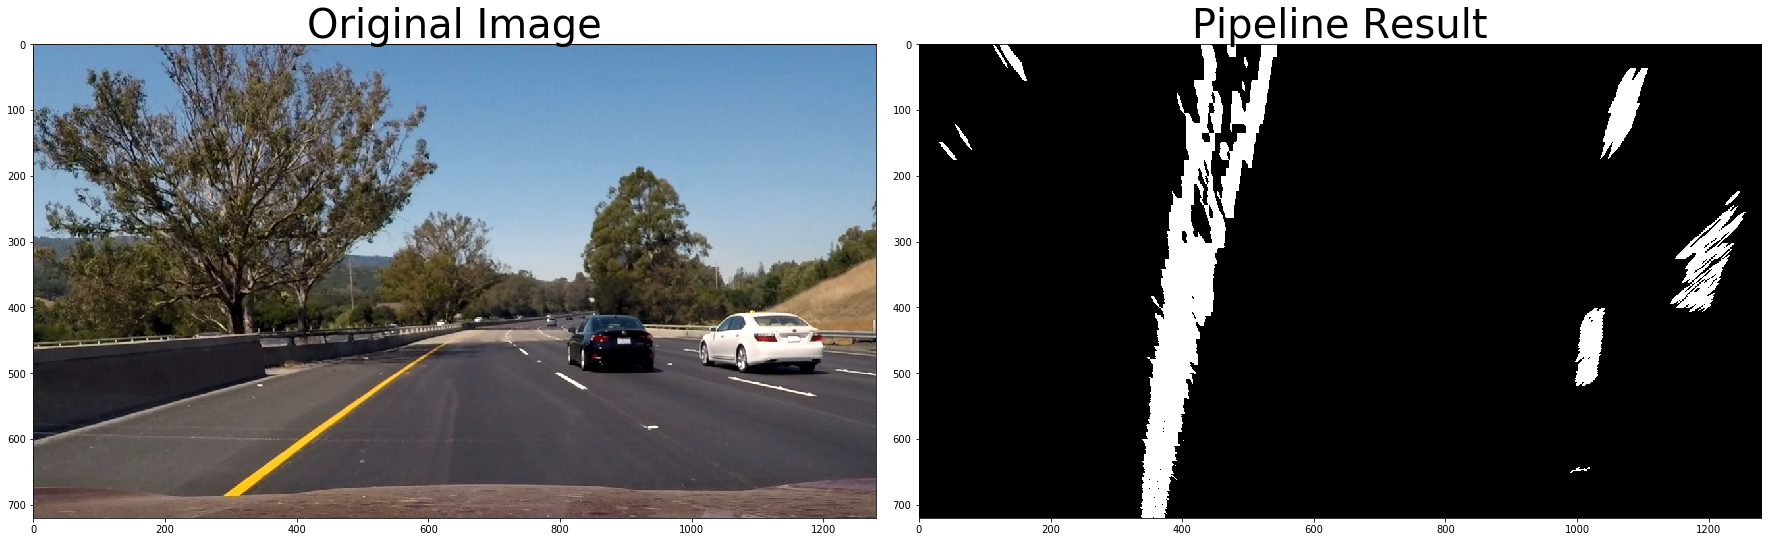

In [14]:
class Perspective_Transformer:
    def __init__(self, w, h):
        self._dim = (w, h)
        
        vertices = np.array([[
            (w//7, h), (w*2//5, h*5//8), (w*3//5, h*5//8), (w, h)
        ]])
        self._region = vertices
        
        src = np.float32([[282, 669], [548, 483], [745, 483], [1045, 669]])
        dst = np.float32([[w//4, h], [w//4, h * 2 // 5], [w*3//4, h * 2 // 5], [w*3//4, h]])
        self._M = cv2.getPerspectiveTransform(src, dst)
        self._Minv = cv2.getPerspectiveTransform(dst, src)
    
    def _region_of_interest(self, img):
        mask = np.zeros_like(img)
        
        if len(mask.shape) > 2:
            channel_num = mask.shape[2]
            ignore_mask_color = (255,) * channel_num
        else:
            ignore_mask_color = 255
            
        cv2.fillPoly(mask, self._region, ignore_mask_color)
        
        return cv2.bitwise_and(img, mask)
    
    def transform(self, img):
        masked = self._region_of_interest(img)
        return self._perspective_transform(masked)
    
    def _perspective_transform(self, img):
        return cv2.warpPerspective(img, self._M, self._dim, flags=cv2.INTER_LINEAR)
        
    
    
image = mpimg.imread('test_images/test6.jpg')
w, h = image.shape[1::-1]
pt = Perspective_Transformer(w, h)
result = undistortor.undistort(image)
result = grad_pipeline.process(result)
result = pt.transform(result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Find lane

In [17]:
class Lane_Finder:
    def __init__(self, margin=100, minpix=50, nwindows=9,
                ym_per_pix=30/720, xm_per_pix=3.7/700):
        self._margin = margin
        self._minpix = minpix
        self._nwindows = nwindows
        
        self.clear()
        
        self._ym_per_pix = ym_per_pix
        self._xm_per_pix = xm_per_pix
        
    def clear(self):
        self._found = False
        
        self._left_fit = []
        self._right_fit = []
        self._lf_ind = 0
        self._rf_ind = 0
        
    def _find_lane(self, img):
        if not self._found:
            histogram = np.sum(img, axis=0)

            midpoint = np.int(histogram.shape[0] / 2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nwindows = self._nwindows

            window_height = np.int(img.shape[0] / nwindows)

            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            leftx_current = leftx_base
            rightx_current = rightx_base

            margin = self._margin

            minpix = self._minpix

            left_lane_inds = []
            right_lane_inds = []

            for window in range(nwindows):
                win_y_low = img.shape[0] - (window+1) * window_height
                win_y_high = img.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                                 (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                                 (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        else:
            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            
            lf = np.mean(self._left_fit, axis=0)
            rf = np.mean(self._right_fit, axis=0)
            left_eq_pts = lf[0]*(nonzeroy**2) + lf[1]*nonzeroy + lf[2]
            right_eq_pts = rf[0]*(nonzeroy**2) + rf[1]*nonzeroy + rf[2]
            left_lane_inds = ((nonzerox > (left_eq_pts - margin)) & (nonzerox < (left_eq_pts + margin))) 
            right_lane_inds = ((nonzerox > (right_eq_pts - margin)) & (nonzerox < (right_eq_pts + margin))) 

        self._found = False
        if left_lane_inds.size == 0 and right_lane_inds.size == 0:
            left_lane_inds = self._last_left_inds
            right_lane_inds = self._last_right_inds
        elif left_lane_inds.size == 0:
            right_lane_inds = self._last_right_inds
        elif right_lane_inds.size == 0:
            left_lane_inds = self._last_left_inds
        else:
            self._found = True

        self._last_left_inds = left_lane_inds
        self._last_right_inds = right_lane_inds

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty
    
    def process(self, img, plot=False):
        pts = leftx, lefty, rightx, righty = self._find_lane(img)
        if plot:
            self._plot(img, *pts)

        if self._found:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            left_fit_cr = np.polyfit(lefty * self._ym_per_pix,
                                    leftx * self._xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty * self._ym_per_pix,
                                    rightx * self._xm_per_pix, 2)
        
            y_eval = img.shape[0]
            left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self._ym_per_pix +
                                  left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
            right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * self._ym_per_pix +
                                  right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
            # sanity check
            curve_diff = abs(left_curverad - right_curverad) / (left_curverad + right_curverad)
            if curve_diff < 0.7:
                self._left_curverad = left_curverad
                self._right_curverad = right_curverad
                if len(self._left_fit) < 8:
                    self._left_fit.append(left_fit)
                    self._right_fit.append(right_fit)
                    self._lf_ind += 1
                    self._rf_ind += 1
                else:
                    self._lf_ind += 1
                    self._rf_ind += 1
                    self._lf_ind %= 8
                    self._rf_ind %= 8
                    self._left_fit[self._lf_ind] = left_fit
                    self._right_fit[self._rf_ind] = right_fit
            else:
                left_curverad = self._left_curverad
                right_curverad = self._right_curverad
            if leftx.size > rightx.size:
                curverad = left_curverad
            else:
                curverad = right_curverad
            
        return curverad, sum(self._left_fit) / len(self._left_fit), sum(
            self._right_fit) / len(self._right_fit)
    
    def _plot(self, img, *pts):
        leftx, lefty, rightx, righty = pts
        margin = self._margin
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        print(self._left_fit)
        lf = np.mean(self._left_fit, axis=0)
        rf = np.mean(self._right_fit, axis=0)
        left_fitx = lf[0]*ploty**2 + lf[1]*ploty + lf[2]
        right_fitx = rf[0]*ploty**2 + rf[1]*ploty + rf[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        
lane_finder = Lane_Finder()

### Pipeline

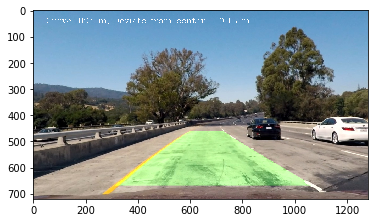

In [18]:
class Lane_Processing_Pipeline:
    def __init__(self, undistortor=Image_Undistortor(),
                grad_pipe=Color_Grad_Pipeline(),
                perspective_transformer=Perspective_Transformer(1280, 720),
                lane_finder=Lane_Finder()):
        self._undistortor = undistortor
        self._grad_pipe = grad_pipe
        self._perspective_transformer = perspective_transformer
        self._lane_finder = lane_finder
        
    def process(self, image):
        undist = self._undistortor.undistort(image)
        output = self._grad_pipe.process(undist)
        output = self._perspective_transformer.transform(output)
        curverad, left_fit, right_fit = self._lane_finder.process(output)
    
        width, height = image.shape[1::-1]
        ploty = np.linspace(0, height-1, height)
        
        warp = np.zeros_like(image).astype(np.uint8)
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
    
        cv2.fillPoly(warp, np.int_([pts]), (0, 255, 0))
        
        newwarp = cv2.warpPerspective(warp, self._perspective_transformer._Minv,
                                     (width, height))
        result = cv2.addWeighted(undist, 1, newwarp, .3, 0)
        
        # stat
        left_pos, right_pos = left_fitx[-1], right_fitx[-1]
        mid_pos = (left_pos + right_pos) / 2
        deviate = width / 2 - mid_pos
        deviate *= self._lane_finder._xm_per_pix
        
        stat_str = 'Curve: {:.0f} m; Deviate from center: {:.2f} m'.format(curverad, deviate)
        cv2.putText(result, stat_str, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255))
        
        return result
    
    def clear(self):
        self._lane_finder.clear()
        
        

pipeline = Lane_Processing_Pipeline(undistortor, grad_pipeline,
                                   pt, lane_finder)
image = plt.imread('test_images/test1.jpg')
result = pipeline.process(image)

plt.imshow(result)

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline.clear()
output = 'output.mp4'
clip = VideoFileClip('project_video.mp4')#.subclip(40,43)
result = clip.fl_image(pipeline.process)

%time result.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [02:51<00:00,  7.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 17s, sys: 11 s, total: 3min 28s
Wall time: 2min 51s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))